In [1]:
import sys
import os
import time

import numpy as np
import sklearn
import PIL
import gzip

    
    # we'll use tensorflow and keras for neural networks
import tensorflow as tf
import tensorflow.keras as keras
    
    # import layers we may use
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout

    # import callbacks we may use
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from PIL import Image
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 16})


In [2]:
# Source: https://stackoverflow.com/questions/57236997/cnn-on-fashion-mnist-dataset
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [3]:
train_x, train_y = load_mnist('.\Data', kind='train')
test_x, test_y = load_mnist('.\Data', kind='t10k')
train_x=train_x/255.0
test_x=test_x/255.0
train_x=train_x.reshape([train_x.shape[0],28,28,1])
test_x=test_x.reshape([test_x.shape[0],28,28,1])
labels=np.array(['Benign','Malware'])
print(train_x.shape)
print(test_x.shape)

(128433, 28, 28, 1)
(14267, 28, 28, 1)


In [4]:
# Code from Vincent Bindschaedler 
def plot_images(im, dim_x=28, dim_y=28, one_row=False, out_fp='out.png', save=False, show=True, cmap='gray', fig_size=(14,14), titles=None, titles_fontsize=12):
    fig = plt.figure(figsize=fig_size)
    im = im.reshape((-1, dim_x, dim_y))

    num = im.shape[0]
    assert num <= 3 or np.sqrt(num)**2 == num or one_row, 'Number of images is too large or not a perfect square!'
    
    if titles is not None:
        assert num == len(titles)
    
    if num <= 3:
        for i in range(0, num):
            plt.subplot(1, num, 1 + i)
            plt.axis('off')
            if type(cmap) == list:
                assert len(cmap) == num
                plt.imshow(im[i], cmap=cmap[i]) # plot raw pixel data
            else:
                plt.imshow(im[i], cmap=cmap) # plot raw pixel data
            if titles is not None:
                plt.title(titles[i], fontsize=titles_fontsize)
    else:
        sq = int(np.sqrt(num))
        for i in range(0, num):
            if one_row:
                plt.subplot(1, num, 1 + i)
            else:
                plt.subplot(sq, sq, 1 + i)
            plt.axis('off')
            if type(cmap) == list:
                assert len(cmap) == num
                plt.imshow(im[i], cmap=cmap[i]) # plot raw pixel data
            else:
                plt.imshow(im[i], cmap=cmap) # plot raw pixel data
            if titles is not None:
                plt.title(titles[i], fontsize=titles_fontsize)
    if save:
        plt.savefig(out_fp)

    if show:
        plt.show()
    else:
        plt.close()

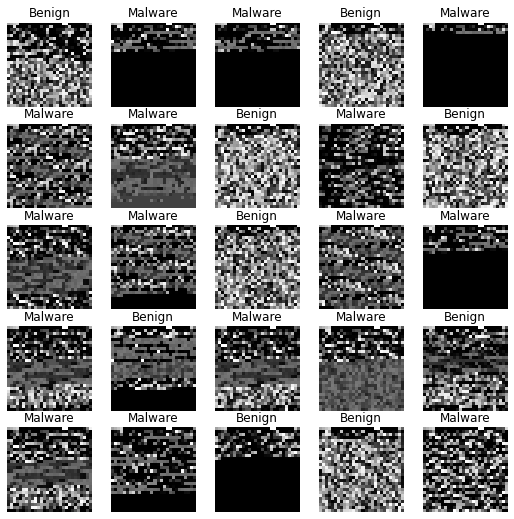

In [5]:
num_images = 25
label_idx = train_y[:num_images].astype(int)
titles = labels[label_idx]
plot_images(train_x[:num_images].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(9,9), titles=titles)

In [6]:
model = keras.models.Sequential(name='Traffic-Classification-CNN');
model.add(Conv2D(32, (5,5), activation='relu',padding='same', input_shape=(28,28,1), name='conv1'));
model.add(MaxPooling2D((2,2),name='maxpool1'));
model.add(Conv2D(64, (5,5), activation='relu',padding='same', name='conv2'));
model.add(MaxPooling2D((2,2),name='maxpool2'));

model.add(Flatten());

model.add(Dense(1024, activation = 'relu', name='fc1'));
model.add(Dropout(0.5,name='dropout1'));
model.add(Dense(1,activation='sigmoid',name='output'));

opt = keras.optimizers.SGD(learning_rate=1e-3);

model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])



In [7]:
if os.path.exists('./traffic-classification-cnn-2.h5'):
    model=keras.models.load_model('./traffic-classification-cnn-2.h5')
else:
    history = model.fit(train_x, train_y, epochs=40, batch_size=50)
    model.save('./traffic-classification-cnn-2.h5')

In [8]:
pred_val=model.predict(test_x);
print(pred_val);
print(test_y)
loss, acc = model.evaluate(test_x, test_y, verbose=0)

print('[Model] Test accuracy: {:.11f}%'.format(100*acc))

[[9.9999511e-01]
 [1.3519965e-04]
 [9.9998081e-01]
 ...
 [9.9999845e-01]
 [8.5121763e-05]
 [1.5943886e-05]]
[1 0 1 ... 1 0 0]
[Model] Test accuracy: 99.99299049377%


In [9]:
if os.path.exists('./model-2.tflite'):
    tflite_interpreter = tf.lite.Interpreter(model_path='./model-2.tflite')
else:
    history = model.fit(train_x, train_y, epochs=40, batch_size=50)
    model.save('./traffic-classification-cnn-2.h5')
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
# Save the model.
with open('model-2.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\echen\AppData\Local\Temp\tmp1y5_memh\assets


In [10]:
tflite_interpreter = tf.lite.Interpreter(model_path='./model-2.tflite')

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: conv1_input
shape: [ 1 28 28  1]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [1 1]
type: <class 'numpy.float32'>


In [11]:
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (14267, 28, 28,1))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (14267, 1))
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [14267    28    28     1]
Input Type: <class 'numpy.float32'>
Output Shape: [14267     1]
Output Type: <class 'numpy.float32'>


In [12]:
test_x.dtype

dtype('float64')

In [16]:
test_x_numpy=np.array(test_x,dtype=np.float32)
print(test_x_numpy.shape)

(14267, 28, 28, 1)


In [ ]:
from sklearn.metrics import accuracy_score
tflite_interpreter.set_tensor(input_details[0]['index'], test_x_numpy)
tflite_interpreter.invoke()
tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = (tflite_model_predictions >= 0.5).astype(int)
acc = accuracy_score(prediction_classes, test_y[0])
print('Test accuracy TFLITE model :', acc)
